# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [82]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq

## SCIP computed features

In [245]:
df = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/202110271339/features.parquet").to_pandas()

In [246]:
df["meta_object_number"] = df.index.map(lambda a: a.split("_")[1]).astype(int)

In [247]:
df["meta_sample"] = df["meta_1"].map(lambda p: Path(p).parts[-2])

In [248]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/meta/pop"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
    with open(pop_file, "r") as fh:
        content = fh.read()
        if len(content) > 0:
            indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
            for idx in indices:
                pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 4)+1:]

In [249]:
def map_to_class(x):
    try:
        return pops[x.meta_sample][x.meta_object_number]
    except KeyError:
        return "unknown"
df["meta_class"] = df.apply(map_to_class, axis=1)

<AxesSubplot:xlabel='count', ylabel='meta_group'>

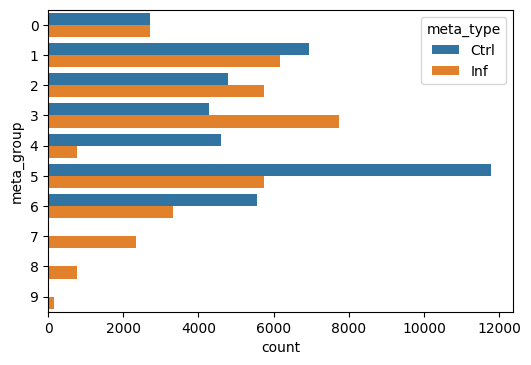

In [250]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_type")

In [251]:
df["meta_class"].value_counts()

unknown       54996
mcp-_psba+    14591
mcp+_psba+     3299
mcp+_psba-     1875
mcp-_psba-     1302
Name: meta_class, dtype: int64

In [252]:
df.shape

(76063, 621)

## NaN filter

In [253]:
sel1 = df["meta_bbox_maxc"].isna()
sel2 = df["meta_class"] != "unknown"

df[sel1 & sel2]["meta_1"].shape

(716,)

In [274]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(74506, 593)

In [275]:
df = df.drop(columns=df.columns[df.isna().all(axis=0)])
df.shape

(74506, 593)

In [286]:
df[df["feat_perimeter_2"].isna()]["meta_1"].iloc[0]

'/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/images/Ctrl_T0_R1/10004_Ch1.ome.tif'

In [291]:
df[(df["feat_perimeter_2"].isna()) & (df["meta_regions_2"] == 1)]["meta_1"].iloc[0]

'/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/images/Ctrl_T1_R2/23265_Ch1.ome.tif'

In [280]:
df.isna().sum(axis=0).sort_values(ascending=False)

meta_suffix                    66218
feat_glcm_contrast_1_1_2       31943
feat_perimeter_2               31943
feat_glcm_energy_1_1_2         31943
feat_glcm_correlation_1_1_2    31943
                               ...  
feat_glcm_energy_1_1_0             0
feat_glcm_correlation_1_1_0        0
feat_glcm_ASM_1_1_0                0
feat_hog_0_0                       0
meta_class                         0
Length: 593, dtype: int64

In [222]:
cols = df.filter(regex="feat").columns[df.filter(regex="feat").isna().any(axis=0)]
df = df.drop(columns=cols)

In [256]:
df["meta_class"].value_counts()

unknown       54155
mcp-_psba+    13950
mcp+_psba+     3258
mcp+_psba-     1853
mcp-_psba-     1290
Name: meta_class, dtype: int64

# Number of identified regions per channel 

/scratch/leuven/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


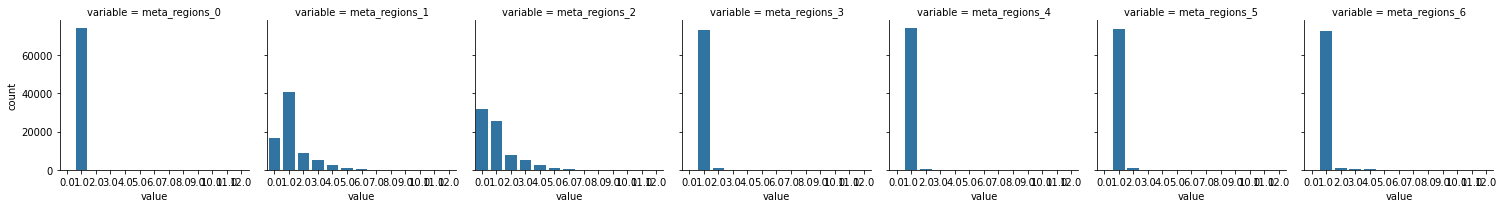

In [270]:
tmp = pandas.melt(df.reset_index(), id_vars=["idx"], value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

In [226]:
df = df[~((df["meta_regions_1"] > 1) & (df["meta_type"] == "Ctrl"))]

In [227]:
df.shape

(62492, 149)

## Zero-variance filter

In [208]:
df.head()

,meta_bbox_minr,meta_bbox_minc,meta_bbox_maxr,meta_bbox_maxc,meta_regions_0,meta_regions_1,meta_regions_2,meta_regions_3,meta_regions_4,meta_regions_5,...,meta_7,meta_9,meta_type,meta_group,meta_replicate,meta_suffix,meta_channel,meta_object_number,meta_sample,meta_class
idx,,,,,,,,,,,,,,,,,,,,,
0_10004,13.0,12.0,25.0,22.0,1.0,0.0,0.0,1.0,1.0,1.0,...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,Ctrl,0,1,None,9,10004,Ctrl_T0_R1,unknown
0_10014,15.0,9.0,29.0,21.0,1.0,0.0,1.0,1.0,1.0,1.0,...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,Ctrl,0,1,None,6,10014,Ctrl_T0_R1,unknown
0_10016,12.0,7.0,24.0,19.0,1.0,0.0,0.0,1.0,1.0,1.0,...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,Ctrl,0,1,None,3,10016,Ctrl_T0_R1,unknown
0_1003,16.0,9.0,28.0,18.0,1.0,1.0,0.0,1.0,1.0,1.0,...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,Ctrl,0,1,None,7,1003,Ctrl_T0_R1,unknown
0_10031,15.0,10.0,27.0,21.0,1.0,1.0,2.0,1.0,1.0,1.0,...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...,Ctrl,0,1,None,6,10031,Ctrl_T0_R1,unknown


In [209]:
df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance

In [210]:
df.shape

(62492, 149)

In [26]:
# export
def df_filter(df):
    df = df.filter(regex="(_[0123]|meta)") # only channels 0 to 3 are of interest
    df = df.loc[:, ~df.isna().all(axis=0)]
    df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance
    
    return df

# Spotting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_0', ylabel='feat_minor_axis_length_0'>

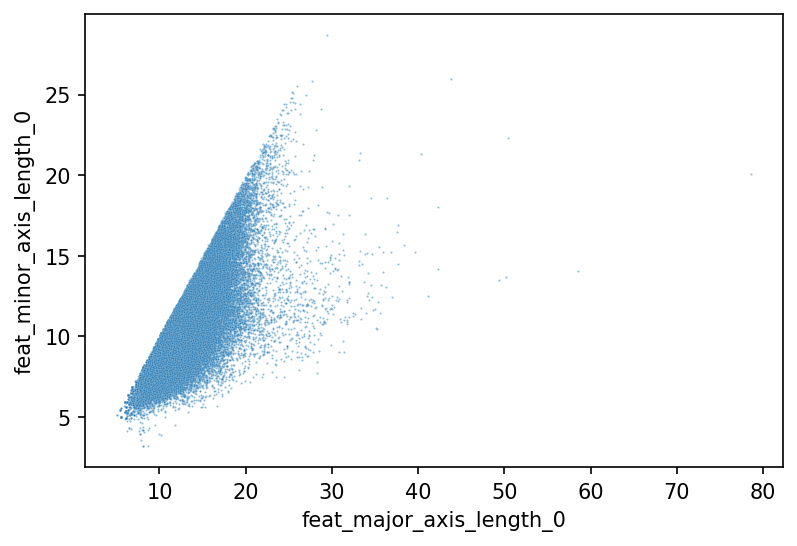

In [150]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_0", y="feat_minor_axis_length_0", s=1, alpha=0.5)

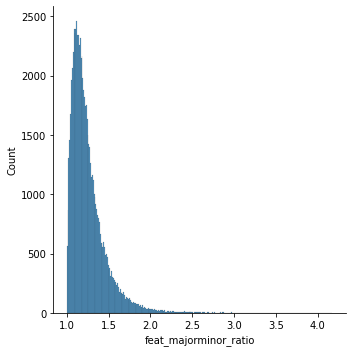

In [151]:
df["feat_majorminor_ratio"] = df["feat_major_axis_length_0"] / df["feat_minor_axis_length_0"]
ax = seaborn.displot(data=df, x="feat_majorminor_ratio")

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

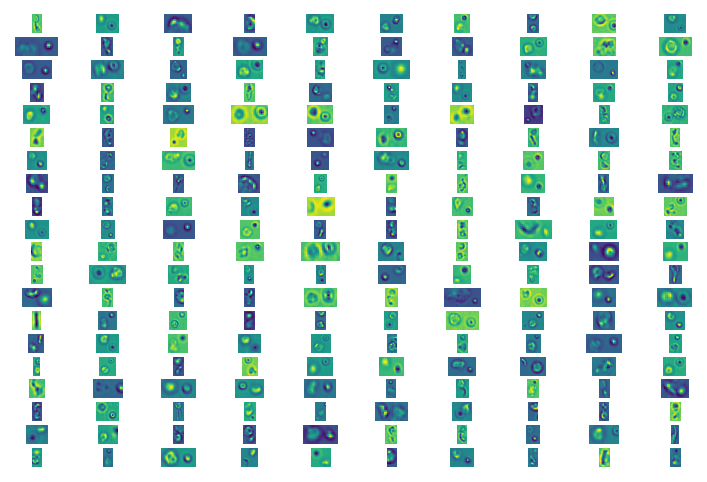

In [28]:
sel1 = df["feat_majorminor_ratio"] > 2.0

core.plot_gate(sel1, df)

In [29]:
df = df[~sel1]
df.shape

(60853, 466)

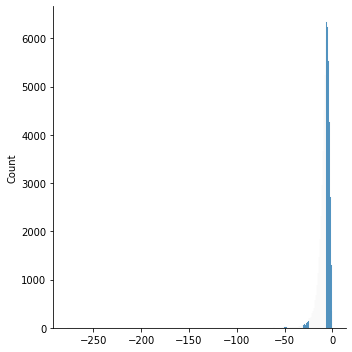

In [37]:
seaborn.displot(data=df["feat_area_0"] - df["feat_convex_area_0"])

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

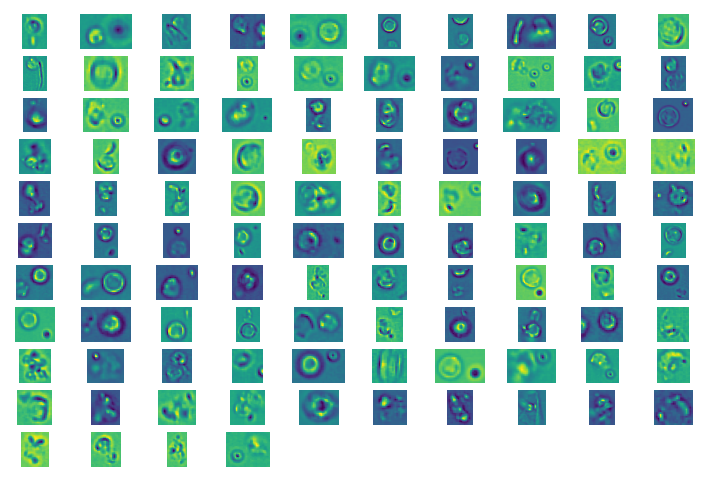

In [40]:
sel1 = (df["feat_area_0"] - df["feat_convex_area_0"]) < -50

core.plot_gate(sel1, df)

In [41]:
df = df[~sel1]
df.shape

(60749, 466)

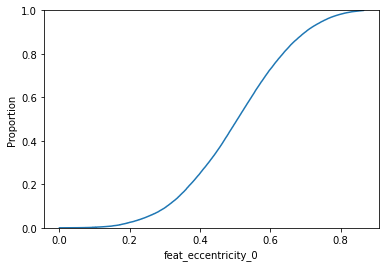

In [42]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_0")

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

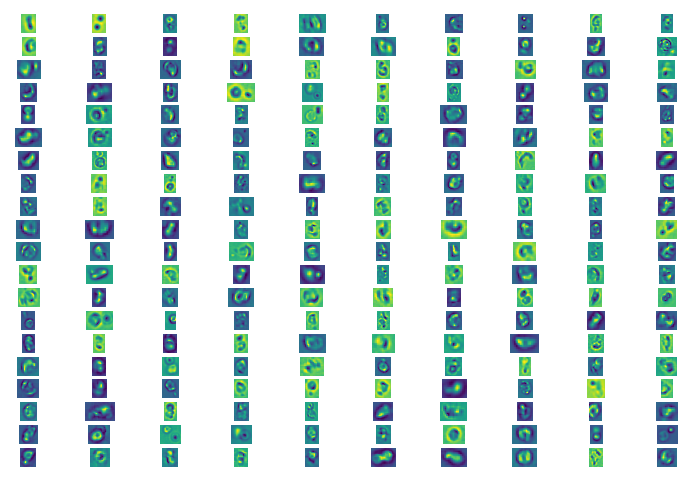

In [43]:
sel1 = df["feat_eccentricity_0"] > 0.7

core.plot_gate(sel1, df)

In [44]:
df = df[~sel1]
df.shape

(54726, 466)

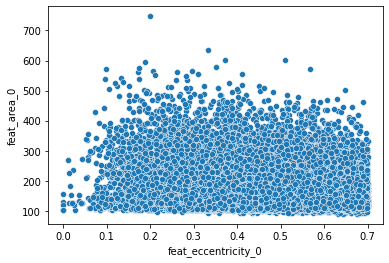

In [45]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_0", y="feat_area_0")

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER


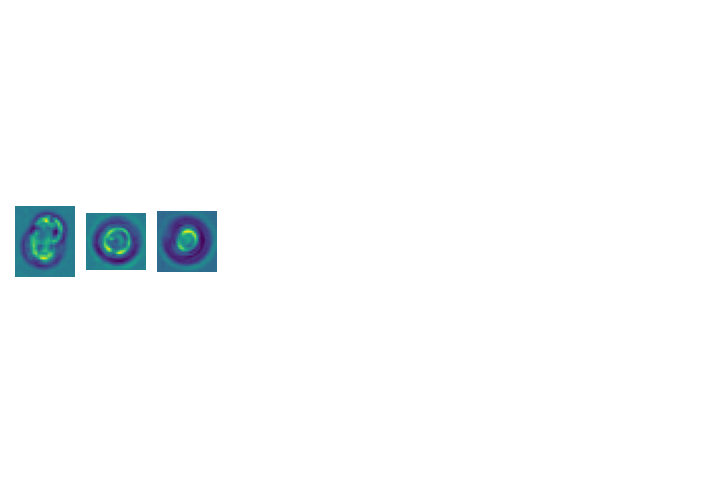

In [48]:
sel1 = df["feat_area_0"] > 500
sel2 = df["feat_eccentricity_0"] > 0.5
core.plot_gate(sel1 & sel2, df)

# Noisy events

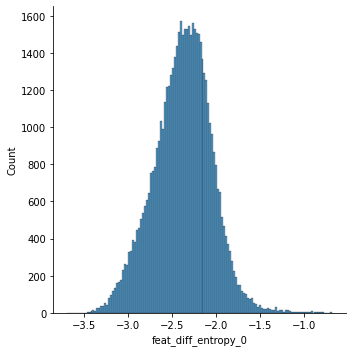

In [49]:
grid = seaborn.displot(data=df, x="feat_diff_entropy_0")

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

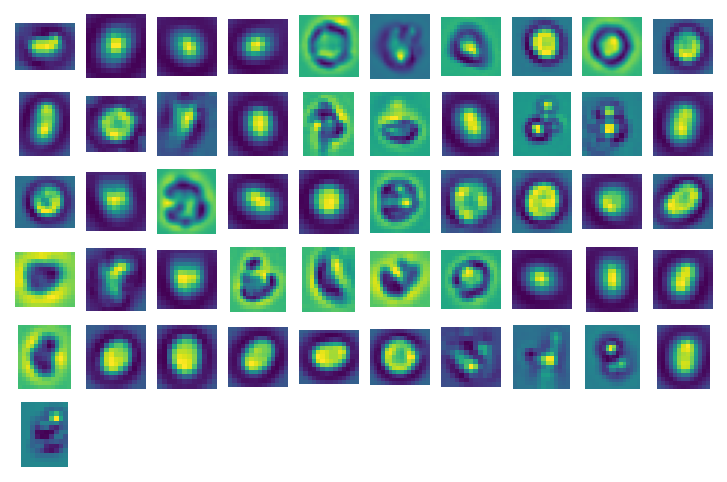

In [50]:
core.plot_gate(df["feat_diff_entropy_0"] > -1.0, df)

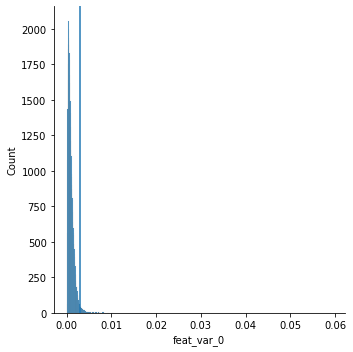

In [51]:
grid = seaborn.displot(data=df, x="feat_var_0")
grid.ax.axvline(0.003)

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

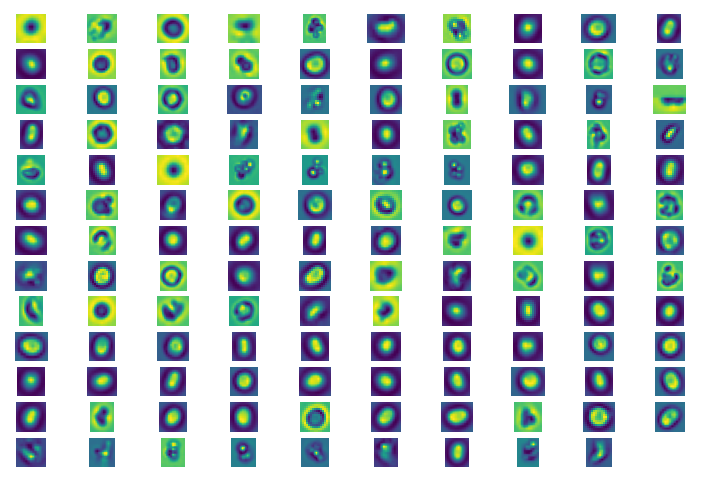

In [52]:
core.plot_gate(df["feat_var_0"] > 0.01, df)

TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 266: 0 is not a valid TIFF.FILLORDER
TiffTag 26

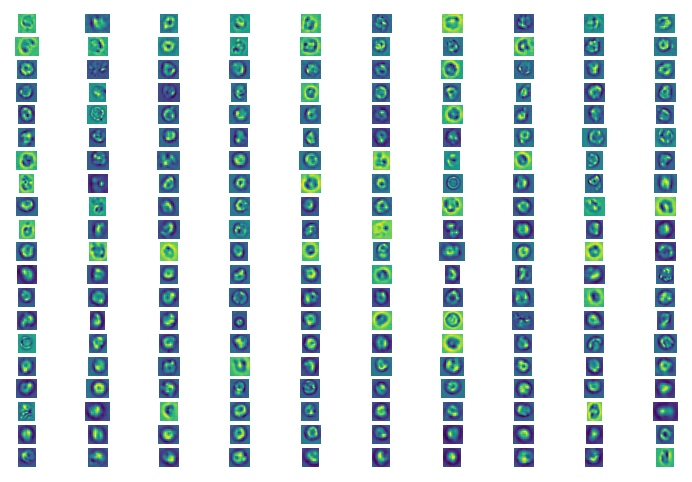

In [53]:
core.plot_gate(df["feat_var_0"] < 0.005, df, sort="feat_var_0")

# Feature correlation

In [54]:
df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance

In [55]:
correlation = df.filter(regex="feat.*").corr()

In [59]:
correlation

,feat_area_0,feat_convex_area_0,feat_eccentricity_0,feat_equivalent_diameter_0,feat_feret_diameter_max_0,feat_filled_area_0,feat_major_axis_length_0,feat_minor_axis_length_0,feat_orientation_0,feat_perimeter_0,...,feat_hog_27_6,feat_hog_28_6,feat_hog_29_6,feat_hog_30_6,feat_hog_31_6,feat_hog_32_6,feat_hog_33_6,feat_hog_34_6,feat_hog_35_6,feat_majorminor_ratio
feat_area_0,1.000000,0.998046,-0.073651,0.993866,0.954259,1.000000,0.947997,0.968480,0.002691,0.972849,...,0.136376,0.010199,0.183388,0.184126,0.063221,0.170929,0.162341,-0.012986,-0.046064,-0.053161
feat_convex_area_0,0.998046,1.000000,-0.052080,0.993308,0.962210,0.998046,0.955527,0.963694,0.002897,0.982557,...,0.136540,0.012053,0.182944,0.183613,0.065186,0.171372,0.161151,-0.012348,-0.043287,-0.031637
feat_eccentricity_0,-0.073651,-0.052080,1.000000,-0.057849,0.143737,-0.073651,0.210188,-0.286425,-0.026896,0.028979,...,-0.007208,0.041357,-0.014144,-0.028797,0.026718,-0.014137,-0.033741,0.026293,0.055187,0.956846
feat_equivalent_diameter_0,0.993866,0.993308,-0.057849,1.000000,0.966020,0.993866,0.959317,0.970331,0.001583,0.982834,...,0.148390,0.012527,0.187175,0.195570,0.071067,0.179916,0.171130,-0.014574,-0.040232,-0.039270
feat_feret_diameter_max_0,0.954259,0.962210,0.143737,0.966020,1.000000,0.954259,0.988602,0.890018,-0.001717,0.980963,...,0.144964,0.021467,0.179788,0.188794,0.080274,0.175928,0.162600,-0.007881,-0.025418,0.168150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feat_hog_32_6,0.170929,0.171372,-0.014137,0.179916,0.175928,0.170929,0.172914,0.175296,-0.028849,0.178374,...,0.653795,0.451022,0.524247,0.569498,0.488491,1.000000,0.486382,-0.048969,0.189179,-0.007046
feat_hog_33_6,0.162341,0.161151,-0.033741,0.171130,0.162600,0.162341,0.157973,0.171249,-0.031049,0.163382,...,0.572525,0.171280,0.483881,0.744878,0.377004,0.486382,1.000000,0.242459,-0.012468,-0.028459
feat_hog_34_6,-0.012986,-0.012348,0.026293,-0.014574,-0.007881,-0.012986,-0.004611,-0.019992,0.029121,-0.011130,...,0.134481,0.069902,0.069778,0.381755,0.181382,-0.048969,0.242459,1.000000,0.137454,0.031132
feat_hog_35_6,-0.046064,-0.043287,0.055187,-0.040232,-0.025418,-0.046064,-0.021326,-0.050404,0.034545,-0.028700,...,0.250965,0.344652,0.061564,0.131171,0.399525,0.189179,-0.012468,0.137454,1.000000,0.056322


## Overall feature correlation

/scratch/leuven/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


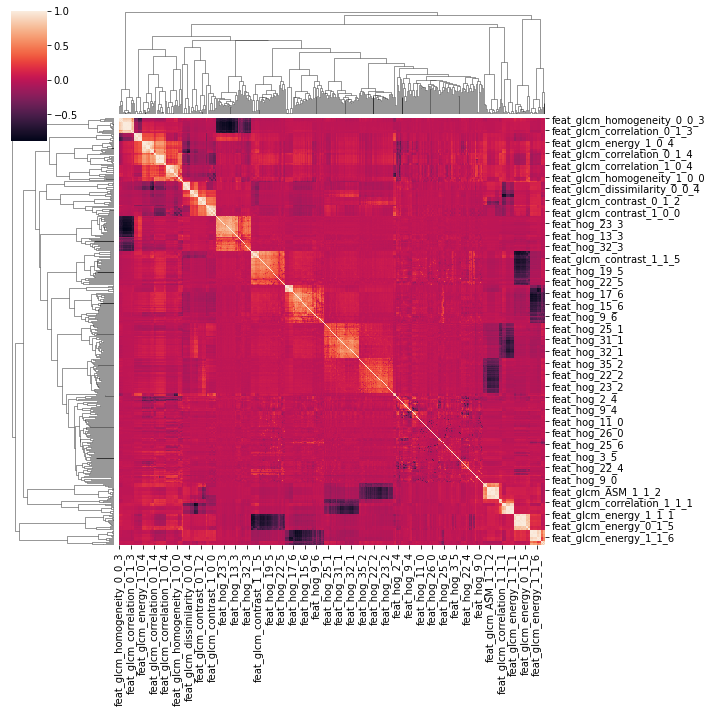

In [60]:
seaborn.clustermap(correlation)

In [62]:
# export
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [63]:
correlated_features = get_correlated_features(df.filter(regex="feat"))
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

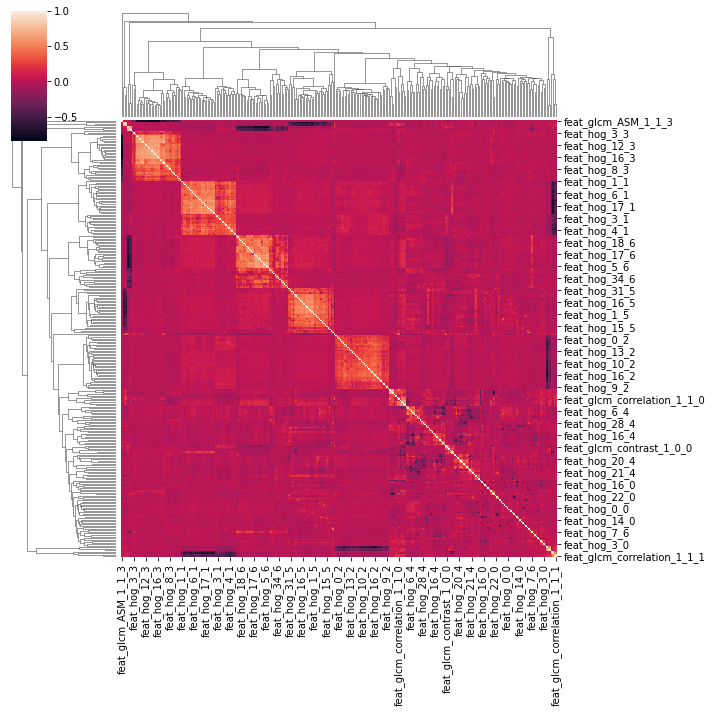

In [64]:
seaborn.clustermap(correlation2)

In [66]:
df = df.drop(columns=correlated_features)

In [67]:
df.shape

(54726, 313)

In [68]:
len(df.index.values)

54726

In [69]:
numpy.save("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/meta/single_focused_index.npy", df.index.values)